In [3]:
import random, math
import json, os

print("Generating data ..", end='', flush=True)
os.makedirs("data/fraud-data", exist_ok=True)


fraudZip = [random.randint(math.pow(10, 3), 2*math.pow(10, 4)) for i in range(0, 1000)]
def zipCode(fraud):
#	if(fraud and random.randint(0, 10) < 5):
#		return fraudZip[random.randint(0, 100-2)]
#	else:
	return random.randint(math.pow(10, 3), math.pow(10, 4))

def transactionId():
	return random.randint(math.pow(10,9), math.pow(10, 10))

def fraudCategory():
	rand = random.randint(0, 10)
	if(rand > 5):
		return 4
	if(rand > 2):
		return 3
	return rand

def basket(fraud):
	size = max((int)(random.gauss(5, 3)),1)
	if(fraud):
		return [fraudCategory() for i in range(0, size)]
	else:
		return [random.randint(0, 5) for i in range(0, size)]

def totalAmount(fraud, itemsInBasket):
	if(fraud):
		return itemsInBasket*max((int)(random.gauss(70, 30)),10)
	else:
		return itemsInBasket*max((int)(random.gauss(50, 30)),10)

def jsonLine():
	fraud = random.randint(0, 100) < 3
	basketItems = basket(fraud)
	return json.dumps({
		"transactionId": transactionId(),
		"basket": basketItems,
		"zipCode": zipCode(fraud),
		"totalAmount": totalAmount(fraud, len(basketItems)),
		"fraudLabel": 1 if(fraud) else 0
		})

def createLog(day):
	textFile = open("data/fraud-data/"+day+".txt", 'w')
	for i in range(0, 1000):
		textFile.write(jsonLine() + "\n")
	textFile.close()

for i in range(1,32):
	print(".",end='', flush=True)
	createLog("2017-01-{0:02d}".format(i))
print("done!")

Generating data .................................done!


In [2]:
import random, math
import json, os
import pandas as pd
jsons = os.listdir('data/fraud-data')
nfiles = len(jsons)

data = pd.DataFrame()
for i in range(nfiles):
    data_temp = pd.read_json('data/fraud-data/{}'.format(jsons[i]),lines=True)
    data = pd.concat([data,data_temp],axis=0)       

print(data.info())

columns = ['zipCode','basket','totalAmount','fraudLabel']
data = data[columns]

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31000 entries, 0 to 999
Data columns (total 5 columns):
basket           31000 non-null object
fraudLabel       31000 non-null int64
totalAmount      31000 non-null int64
transactionId    31000 non-null int64
zipCode          31000 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.4+ MB
None


,zipCode,basket,totalAmount,fraudLabel
0,5708,"[1, 4, 0, 2, 0]",345,0
1,8507,"[1, 5, 2]",180,0
2,5031,"[2, 1, 4, 5, 5, 4]",342,0
3,7689,[5],115,0
4,1085,"[2, 0]",20,0


In [3]:
print('Total rows = '+str(len(data['basket'].str.len())))
print('Max basket items = '+str(max(data['basket'].str.len())))
print('Min basket items = '+str(min(data['basket'].str.len())))
print('Avg basket items = '+str((data['basket'].str.len()).mean()))

Total rows = 31000
Max basket items = 16
Min basket items = 1
Avg basket items = 4.659612903225806


In [4]:
# we need to label encode the basket column

# find the total number of categories in the basket
max_list = [max(data['basket'].iloc[i]) for i in range(len(data))]
total_cats = max(max_list)

# the map function allows us to apply a function to only a specified column in the dataframe
# our small lambda function can then count the number of elements by category in the list
# we can then create new columns
for i in range(total_cats+1):
    data['Cat{}'.format(i)] = data['basket'].map(lambda x: x.count(i))
    
# I want to also see how many items someone bought
data['totalItems'] = data['basket'].map(lambda x: len(x))
    
data.head()

,zipCode,basket,totalAmount,fraudLabel,Cat0,Cat1,Cat2,Cat3,Cat4,Cat5,totalItems
0,5708,"[1, 4, 0, 2, 0]",345,0,2,1,1,0,1,0,5
1,8507,"[1, 5, 2]",180,0,0,1,1,0,0,1,3
2,5031,"[2, 1, 4, 5, 5, 4]",342,0,0,1,1,0,2,2,6
3,7689,[5],115,0,0,0,0,0,0,1,1
4,1085,"[2, 0]",20,0,1,0,1,0,0,0,2


In [5]:
print('Total zip codes = '+str(len(data['zipCode'].value_counts())))

Total zip codes = 8720


In [6]:
# select features and labels to train on predict on
features = ['Cat0','Cat0','Cat0','Cat0','Cat0','Cat0','totalItems','totalAmount']
label = 'fraudLabel'
data_features = data[features]
data_label = data[label]

In [7]:
# split data into test and train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features,data_label,test_size=0.3,random_state=0)

In [8]:
# train and predict on a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
acc = logreg.score(X_test,y_test)
print('Mean accuracy of model = '+'{:.2%}'.format(acc))

Mean accuracy of model = 97.10%


In [57]:
# try a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)
acc = gbt.score(X_test,y_test)
print('Mean accuracy of model = '+'{:.2%}'.format(acc))

Mean accuracy of model = 97.06%


In [68]:
# how about looking at a random forest?
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 30)
rfc.fit(X_train,y_train)
acc = rfc.score(X_test,y_test)
print('Mean accuracy of model = '+'{:.2%}'.format(acc))

Mean accuracy of model = 96.87%


In [69]:
# Model estimation
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [70]:
from sklearn import metrics
fpr_reg, tpr_reg, _ =  metrics.roc_curve(y_test, test_scores_reg[:,1])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  metrics.roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

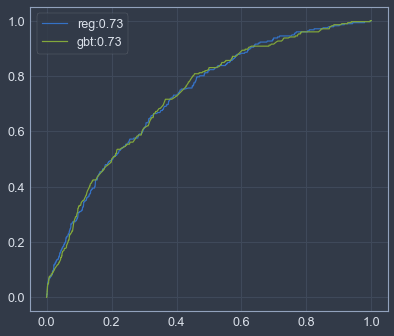

In [221]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style('chesterish')

plt.figure()
plt.plot(fpr_reg, tpr_reg, label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.show()

### Construct a ROC Curve

In [149]:
y_pred_proba = pd.DataFrame(logreg.predict_proba(X_test))
y_pred = pd.DataFrame(logreg.predict(X_test))
y_true = pd.DataFrame(y_test)

predictions = pd.concat([y_pred_proba,y_pred], axis=1)
predictions = pd.concat([predictions,y_true], axis=1)

print(type(y_true))
y_true.shape

ValueError: Shape of passed values is (4, 17600), indices imply (4, 9300)

In [103]:
# sort values by largest probability of fraud
y_pred_proba = y_pred_proba.sort_values(0,axis=0,ascending=True)
y_pred_proba.head(10)

,0,1
7238,0.217014,0.782986
7014,0.538256,0.461744
9239,0.657718,0.342282
8505,0.658713,0.341287
6309,0.668150,0.331850
398,0.679522,0.320478
6413,0.680806,0.319194
6344,0.712483,0.287517
7828,0.714554,0.285446
5848,0.726969,0.273031


In [151]:
def rocPoints(classifier):
    positives = predictions[predictions.label == 1].shape[0]
    negatives = predictions[predictions.label == 0].shape[0]
    fprPoints = [0]
    tprPoints = [0]
    sortedPred = predictions[classifier].sort_values(ascending = False)
    for p in sortedPred:
        aboveThreshold = predictions[predictions[classifier] >= p].label # get part of df above p
        tpr = aboveThreshold[aboveThreshold == 1].shape[0] / float(positives)
        fpr = aboveThreshold[aboveThreshold == 0].shape[0] / float(negatives)
        fprPoints.append(fpr)
        tprPoints.append(tpr)
    return fprPoints, tprPoints

In [100]:
y_pred = pd.DataFrame(logreg.predict(X_test))
y_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [150]:
print(predictions.shape)
print(y_true.shape)

(9300, 3)
(9300, 1)


In [ ]:
positives = predictions

# Rebalancing the problem

In [155]:
# undersample the data
features = ['Cat0','Cat0','Cat0','Cat0','Cat0','Cat0','totalItems','totalAmount']
label = 'fraudLabel'

data = data.drop(['basket','zipCode'],axis=1)
data.head()

,totalAmount,fraudLabel,Cat0,Cat1,Cat2,Cat3,Cat4,Cat5,totalItems
0,345,0,2,1,1,0,1,0,5
1,180,0,0,1,1,0,0,1,3
2,342,0,0,1,1,0,2,2,6
3,115,0,0,0,0,0,0,1,1
4,20,0,1,0,1,0,0,0,2


In [227]:
''' UNDERSAMPLE DATA '''

# find indices where fraud is 0 and fraud is 1
data_pos = data[(data['fraudLabel']==1)]
data_neg = data[(data['fraudLabel']==0)]

print(len(data_pos))
print(len(data_neg))
print(len(data_pos)+len(data_neg))

# sample smaller number from data_neg
data_neg_sample = data_neg.sample(len(data_pos))

# put the data back together
data_rebal = pd.concat([data_pos,data_neg_sample],axis=0)

# select features and labels
data_rebal_features = data_rebal[features]
data_rebal_labels = data_rebal[label]

# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(data_rebal_features,data_rebal_labels,test_size=0.3,random_state=0)

# train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
acc = logreg.score(X_test,y_test)
print('Mean accuracy of model = '+'{:.2%}'.format(acc))

964
30036
31000
Mean accuracy of model = 67.88%


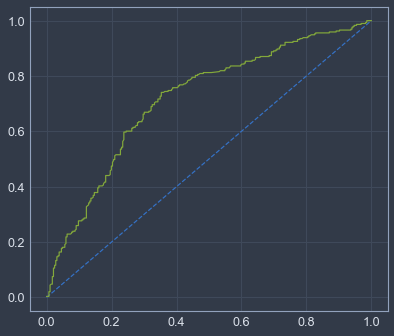

In [228]:
from sklearn.metrics import roc_curve

# predict probabilities
probs = logreg.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()

In [229]:
''' OVERSAMPLE '''

data_pos_over = data_pos.append([data_pos]*31,ignore_index=True)
print(len(data_pos_over))
print(len(data_neg))

data_over = pd.concat([data_pos_over,data_neg],axis=0)
data_over_features = data_over[features]
data_over_labels = data_over[label]

# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(data_over_features,data_over_labels,test_size=0.3,random_state=0)

# train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
acc = logreg.score(X_test,y_test)
print('Mean accuracy of model = '+'{:.2%}'.format(acc))

30848
30036
Mean accuracy of model = 66.23%


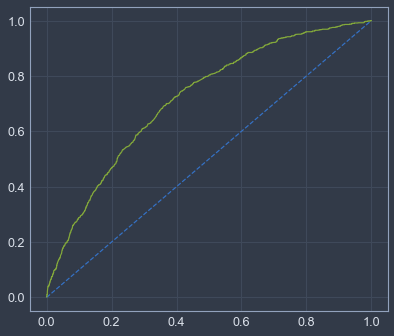

In [230]:
''' LOOK AT AREA UNDER ROC '''

from sklearn.metrics import roc_curve

# predict probabilities
probs = logreg.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()

In [ ]:
# same for undersampling

# predict probabilities
probs = .predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()